# Image segmentation

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def display(img, cmap='gray'):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111)
    ax.imshow(img, cmap)

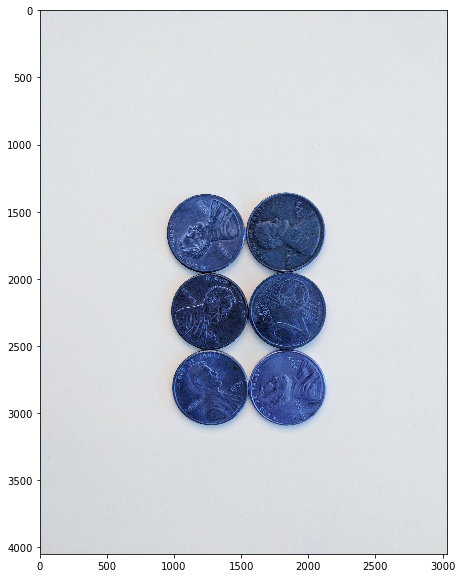

In [3]:
sep_coins = cv2.imread('../DATA/pennies.jpg')
display(sep_coins)

## I. Segmentation using contouring

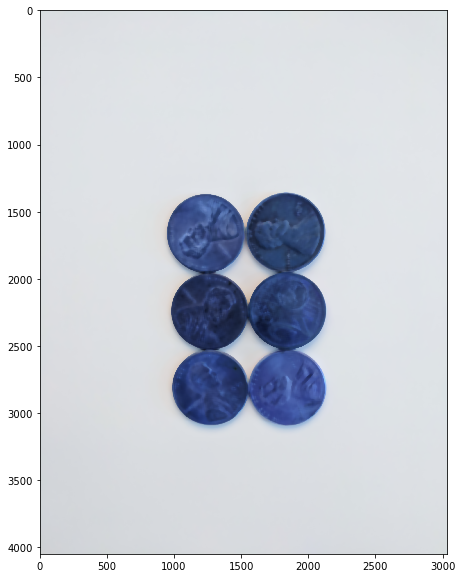

In [4]:
# Apply a median blur
sep_blur = cv2.medianBlur(sep_coins, 25)
display(sep_blur)

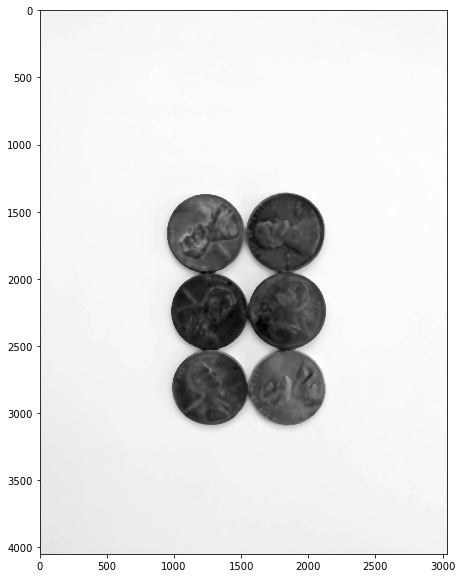

In [5]:
# Turn into gray scale
gray_sep_coins = cv2.cvtColor(sep_blur, cv2.COLOR_BGR2GRAY)
display(gray_sep_coins)

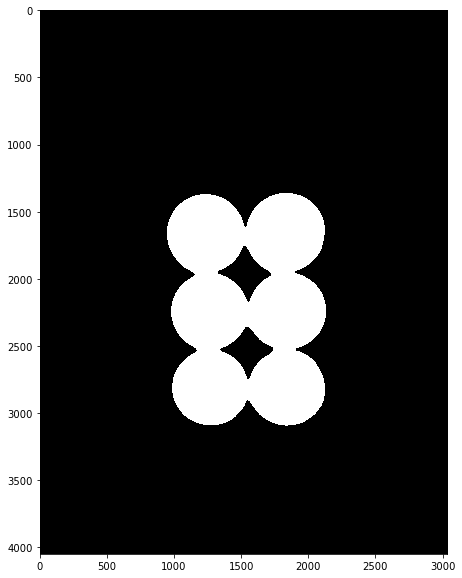

In [9]:
# Apply a binary threshold to turn to fore/background
ret, sep_thresh = cv2.threshold(gray_sep_coins, 160, 255, cv2.THRESH_BINARY_INV)
display(sep_thresh)

In [10]:
image, contours, hierachy = cv2.findContours(sep_thresh.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

In [15]:
for i in range(len(contours)):
    if hierachy[0][i][3] == -1:
        cv2.drawContours(sep_coins, contours, i, (255, 0, 0), 10)

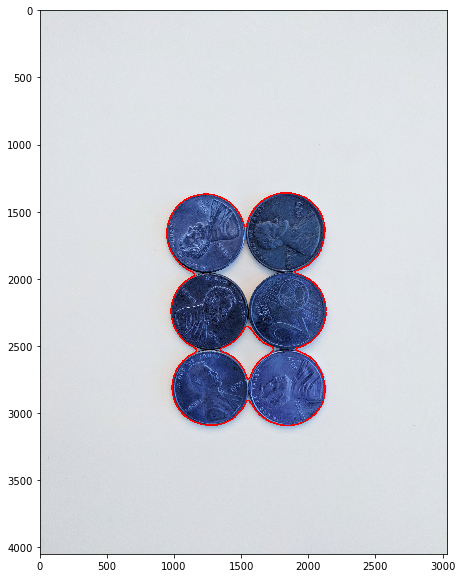

In [16]:
display(sep_coins)

## II. Applying Watershed Algorithm

#### 1. Read image

In [29]:
img = cv2.imread('../DATA/pennies.jpg')

#### 2. Apply a median blur

In [30]:
img = cv2.medianBlur(img, 35)

#### 3. Turn to Gray Scale

In [31]:
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

#### 4. Apply Threshold (Binary + OTSU)

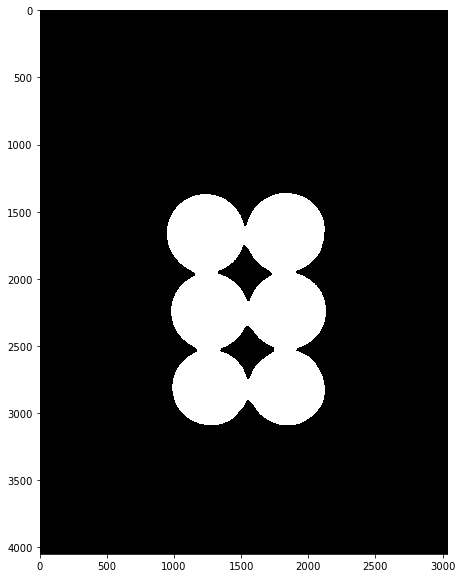

In [32]:
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
display(thresh)

#### 5. Remove noise

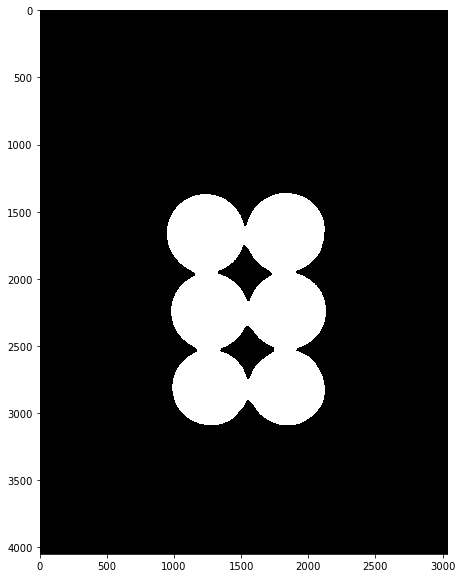

In [33]:
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
display(opening)

#### 6. Grab parts that must be background

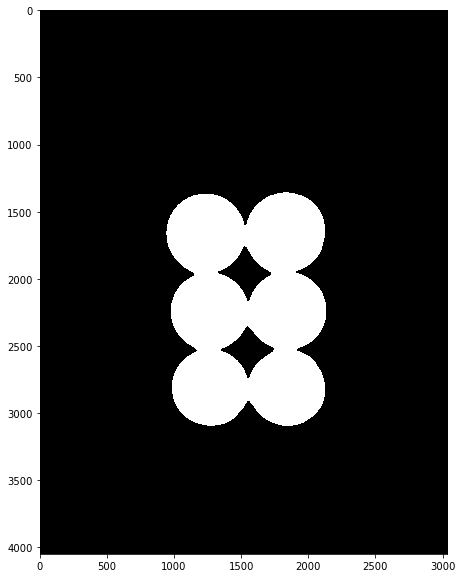

In [34]:
# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)
display(sure_bg)

#### 7. Grab parts that must be foreground

In [35]:
# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)

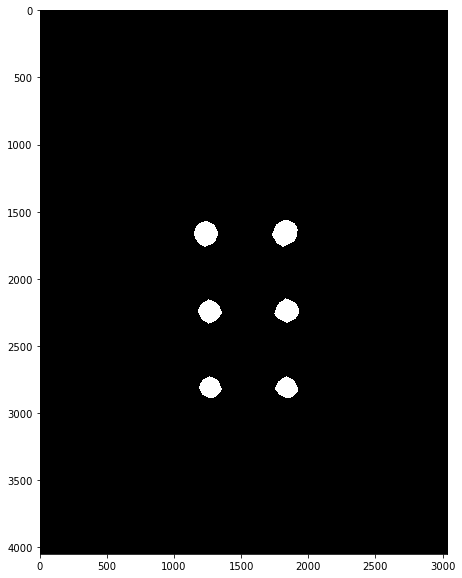

In [36]:
display(sure_fg)

#### 8. Find difference between fore/background

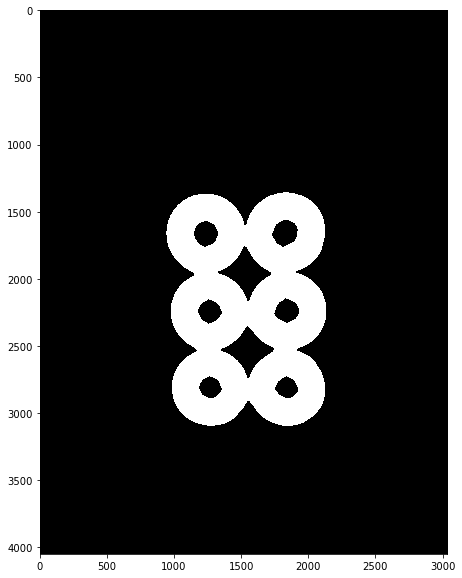

In [38]:
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)
display(unknown)

#### 9: Label Markers of Sure Foreground

In [40]:
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int32)

In [42]:
markers[unknown==255] = 0

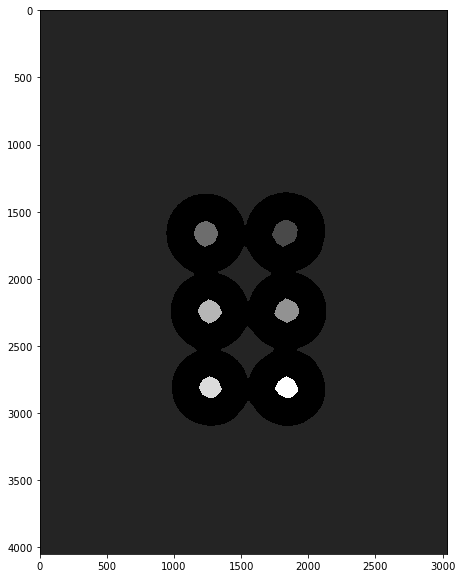

In [43]:
display(markers)

#### 10: Apply Watershed Algorithm to find Markers

In [44]:
markers = cv2.watershed(img, markers)

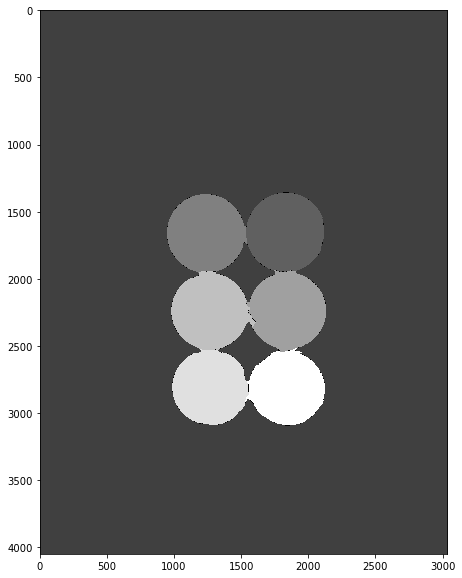

In [45]:
display(markers)

#### 11. Draw contours

In [46]:
image, contours, hierachy = cv2.findContours(markers.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

for i in range(len(contours)):
    if hierachy[0][i][3] == -1:
        cv2.drawContours(sep_coins, contours, i, (255, 0, 0), 10)

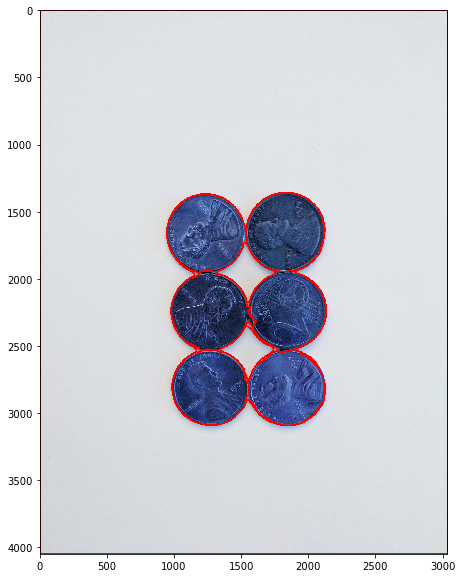

In [47]:
display(sep_coins)

## III. Custom Seeds with Watershed Algorithm

In [48]:
road = cv2.imread('../DATA/road_image.jpg')
road_copy = np.copy(road)

In [49]:
marker_image = np.zeros(road.shape[:2], dtype=np.int32)

In [50]:
segments = np.zeros(road.shape, dtype=np.uint8)

In [51]:
from matplotlib import cm

In [54]:
def create_rgb(i):
    return tuple(np.array(cm.tab10(i)[:3]) * 255)

In [55]:
colors = []
for i in range(10):
    colors.append(create_rgb(i))

In [56]:
colors

[(31.0, 119.0, 180.0),
 (255.0, 127.0, 14.0),
 (44.0, 160.0, 44.0),
 (214.0, 39.0, 40.0),
 (148.0, 103.0, 189.0),
 (140.0, 86.0, 75.0),
 (227.0, 119.0, 194.0),
 (127.0, 127.0, 127.0),
 (188.0, 189.0, 34.0),
 (23.0, 190.0, 207.0)]

In [61]:
###
# Global variables
# Color choice
n_markers = 10
current_marker = 1
marks_updated = False

In [62]:
# Callback function
def mouse_callback(event, x, y, flags, param):
    global marks_updated
    if event == cv2.EVENT_LBUTTONDOWN:
        # Circle for markers passed to watershed algo
        cv2.circle(marker_image, (x, y), 10, (current_marker), -1)
        # User sees on image
        cv2.circle(road_copy, (x, y), 10, colors[current_marker], -1)
        marks_updated = True

In [65]:
cv2.namedWindow('Road Image')
cv2.setMouseCallback('Road Image', mouse_callback)

while True:
    cv2.imshow('Watershed Segments', segments)
    cv2.imshow('Road Image', road_copy)
    
    # Close all windows
    k = cv2.waitKey(1)
    if k == 27:
        break
    
    # Clear all current colors
    elif k == ord('c'):
        road_copy = road.copy()
        marker_image = np.zeros(road.shape[:2], dtype=np.int32)
        segments = np.zeros(road.shape, dtype=np.uint8)
    
    # Update color choice
    elif k > 0 and chr(k).isdigit():
        current_marker = int(chr(k))
    
    # Update the markings
    if marks_updated:
        marker_image_copy = marker_image.copy()
        cv2.watershed(road, marker_image_copy)
        
        segments = np.zeros(road.shape, dtype=np.uint8)
        for color_ind in range(n_markers):
            # coloring segments using numpy call
            segments[marker_image_copy == color_ind] = colors[color_ind]
        
        markers_updated = False
            
        
cv2.destroyAllWindows()